In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts/')
import warnings
warnings.filterwarnings('ignore')

from utils import Utils
from datacleaner import DataCleaner
from model import Model
import mlflow
import mlflow.tensorflow
from feature_engineering import FeatureEngineering
from datetime import datetime
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout


In [2]:
utils = Utils()
cleaner = DataCleaner()

In [3]:
latest_df = utils.load_data_dvc('v2-merged','data/feature_engineered_df.csv','/home/teddy/dev/learning/10 academy/working/pharma_sales_prediction')

In [4]:
latest_df.sort_values(by='Date', inplace=True)

train_split, test_split = latest_df.iloc[:int(len(latest_df)*.8), :], latest_df.iloc[int(len(latest_df)*.8):, :]

In [5]:
X_train = []
y_train = []

n_future = 1
n_past = 32
train_split = train_split.iloc[:20_000, :]
test_split = test_split.iloc[:20_000, :]
for i in range(n_past, len(train_split) - n_future +1):
    X_train.append(train_split.iloc[i - n_past:i, :])
    y_train.append(train_split.iloc[i:i + n_future, 0])


X_test = []
y_test = []
for i in range(n_past, len(test_split) - n_future +1):
    X_test.append(test_split.iloc[i - n_past:i, :])
    y_test.append(test_split.iloc[i:i + n_future, 0])

In [6]:
# Let's turn them into numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
print("X_train data shape:", X_train.shape)
print("y_train data shape:", y_train.shape)

X_test, y_test = np.array(X_test), np.array(y_test)
print("X_test data shape:", X_test.shape)
print("y_test data shape:", y_test.shape)

X_train data shape: (19968, 32, 26)
y_train data shape: (19968, 1)
X_test data shape: (19968, 32, 26)
y_test data shape: (19968, 1)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [8]:
def get_model():
    model = Sequential()

    # Adding 1st LSTM layer
    model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1:])))
    model.add(Dense(units=64, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256, return_sequences=True))
    #model.add(LSTM(units=1024, return_sequences=True))
    #model.add(Dense(units=512, activation='relu'))

    # Adding 2nd LSTM layer
    model.add(LSTM(units=128, return_sequences=True))

    model.add(LSTM(units=32, return_sequences=False))

    # Adding Dropout
    model.add(Dropout(0.2))
    #model.add(Dense(units=16, activation='relu'))
    # Output layer
    model.add(Dense(units=y_train.shape[1]))
    # # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=0.01), loss='mse')

    return model

# tb = TensorBoard('logs')

In [15]:
mlflow.set_experiment('LSTM-Forecasting')
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.start_run()

<ActiveRun: >

In [16]:
mlflow.tensorflow.autolog(every_n_iter=2)

In [27]:
from sklearn.model_selection import cross_val_score, KFold
k_fold = KFold(n_splits=5, shuffle=False)
fold = 1
train_histories = []
loss_per_fold = []
for train, valid in k_fold.split(X_train, y_train):
    # Get a fress model from the factory :)
    model = get_model()
    # Training utilities
    es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=0)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0)
    mcp = ModelCheckpoint(filepath=f'../models/weights-fold-{fold}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)
    # Start training
    history = model.fit(X_train, 
                    y_train, 
                    shuffle=True, 
                    epochs=100, 
                    callbacks=[es, rlr, mcp], 
                    validation_split=0.2, 
                    verbose=0, 
                    batch_size=64)
    train_histories.append(history)
    print(f"Fold number {fold} complete")
    print("-"*100)
    # Evaluate
    score = model.evaluate(X_test, y_test, verbose=0)
    loss_per_fold.append(score)
    print(f'Score for fold {fold}: {score}')
    fold += 1

INFO:tensorflow:Assets written to: /tmp/tmpm6ng8gqy/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpm6ng8gqy/model/data/model/assets


Fold number 1 complete
----------------------------------------------------------------------------------------------------
Score for fold 1: 103648.8125


INFO:tensorflow:Assets written to: /tmp/tmp3trjpx0t/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp3trjpx0t/model/data/model/assets


Fold number 2 complete
----------------------------------------------------------------------------------------------------
Score for fold 2: 103643.0625


INFO:tensorflow:Assets written to: /tmp/tmpgw0q4v7m/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpgw0q4v7m/model/data/model/assets


Fold number 3 complete
----------------------------------------------------------------------------------------------------
Score for fold 3: 103655.84375


INFO:tensorflow:Assets written to: /tmp/tmp6yjjp7k4/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp6yjjp7k4/model/data/model/assets


Fold number 4 complete
----------------------------------------------------------------------------------------------------
Score for fold 4: 103644.515625


INFO:tensorflow:Assets written to: /tmp/tmpsfluvk9t/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpsfluvk9t/model/data/model/assets


Fold number 5 complete
----------------------------------------------------------------------------------------------------
Score for fold 5: 103658.953125


In [14]:
mlflow.end_run()

In [20]:
reduced_df = train_split.copy()
scaler = MinMaxScaler()
scaler.fit(reduced_df.Sales.values.reshape([-1, 1]))
SalesScaled = scaler.transform(reduced_df.Sales.values.reshape(-1, 1))
reduced_df['SalesScaled'] = SalesScaled
reduced_df.tail(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,weekday,weekend,month,year,day,period_in_month,before_holiday,after_holiday,SalesScaled
504908,667,3,22,8454,731,1,1,0,0,3,...,0,1,0,1,2013,23,2,17,65,0.262034
282297,373,3,22,4090,269,1,1,0,0,3,...,2,1,0,1,2013,23,2,17,65,0.126771
228350,303,3,22,6911,679,1,1,0,0,0,...,1,1,0,1,2013,23,2,17,65,0.214208
322037,425,3,22,3346,424,1,1,0,0,3,...,0,1,0,1,2013,23,2,17,65,0.103710
347012,458,3,22,7021,625,1,1,0,0,2,...,0,1,0,1,2013,23,2,17,65,0.217618
726749,960,3,22,7324,523,1,1,0,0,3,...,1,1,0,1,2013,23,2,17,65,0.227009
770719,1018,3,22,12814,1456,1,1,0,0,2,...,0,1,0,1,2013,23,2,17,65,0.397173
229915,305,3,22,3755,374,1,1,0,0,2,...,3,1,0,1,2013,23,2,17,65,0.116387
785215,1037,3,22,5997,821,1,1,0,0,0,...,0,1,0,1,2013,23,2,17,65,0.185879
698906,924,3,22,5108,466,1,1,0,0,0,...,2,1,0,1,2013,23,2,17,65,0.158324


In [ ]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(reduced_df.Date, latest_df.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(reduced_df.Date, latest_df.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

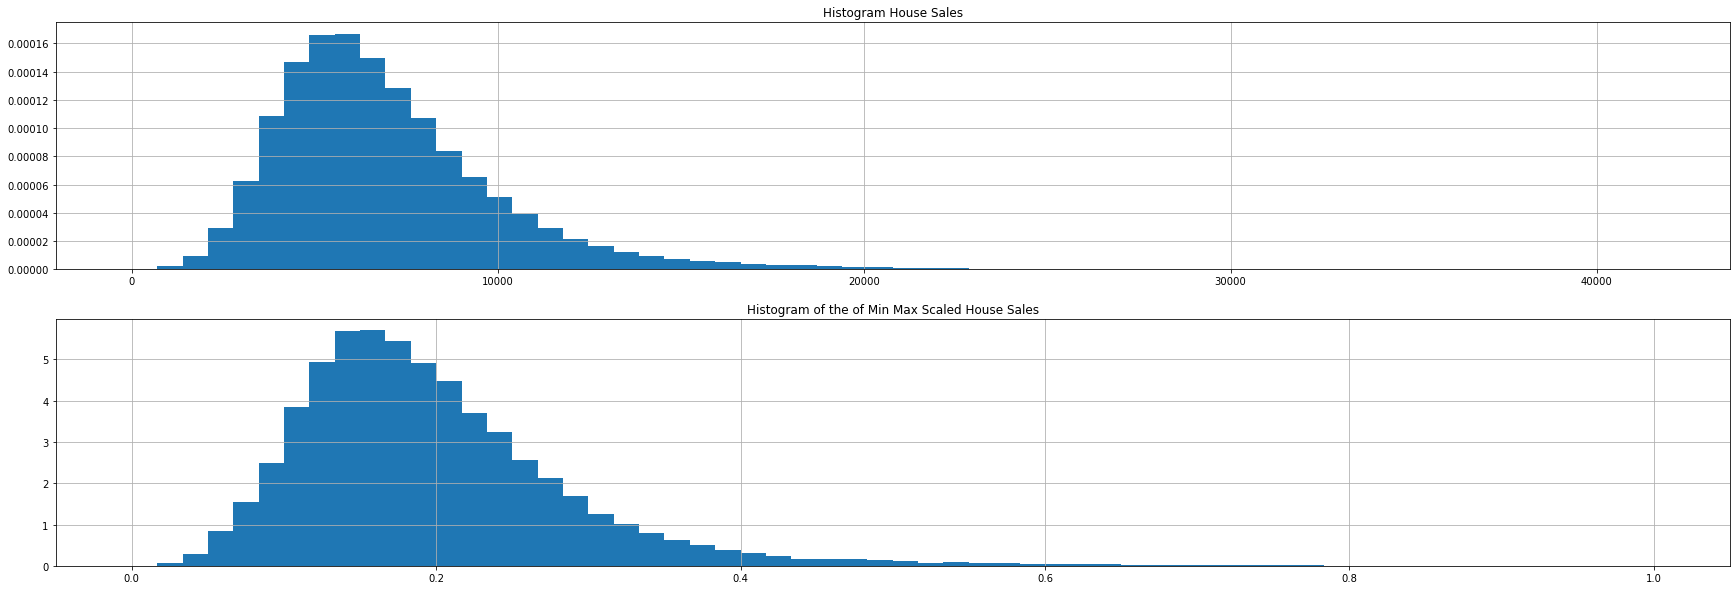

In [26]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(latest_df.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(reduced_df.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

### Unit Root Tests

In [23]:
adfResult = adfuller(reduced_df.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.612133266868626
p-value: 1.1968294943053206e-06


In [24]:
adfResult = adfuller(reduced_df.SalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.612133266868622
p-value: 1.1968294943053382e-06


Removing Stationary

In [7]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [8]:
houseSalesDif = difference(latest_df.SalesScaled.values)

In [9]:
acfSalesScaled = acf(latest_df.SalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [10]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of House Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

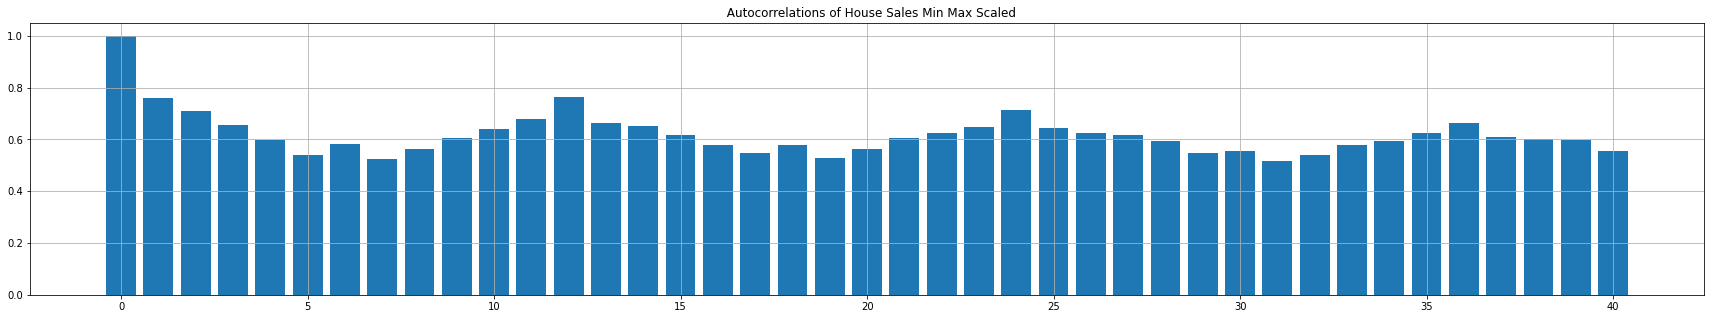

In [11]:
corrPlots(acfSalesScaledNp, '')

In [12]:
pacfSalesScaled = pacf(latest_df.SalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

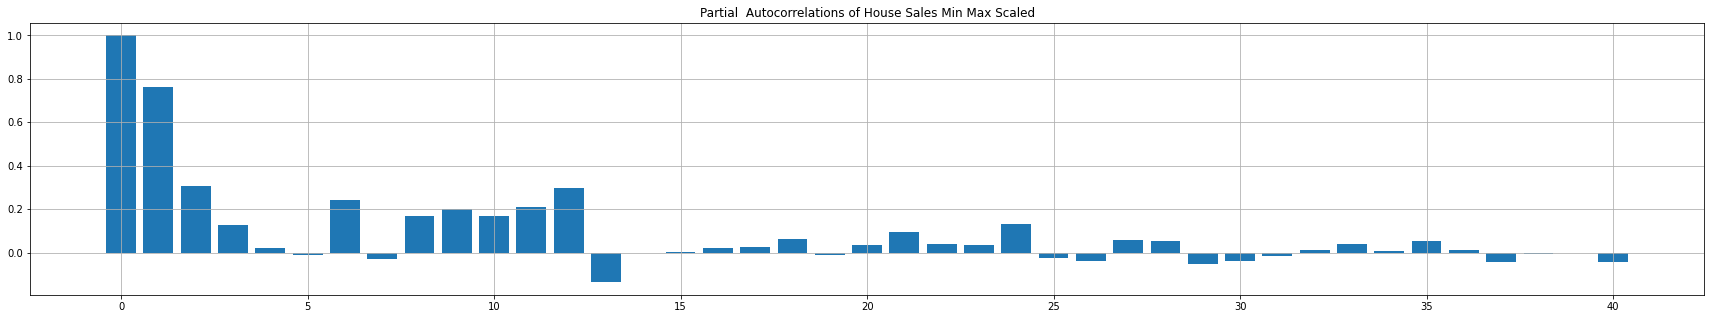

In [13]:
corrPlots(pacfSalesScaledNp, "Partial")